<a href="https://colab.research.google.com/github/johnsona9726/Deep-Learning-Team-9/blob/main/DL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Covid-19 Vaccine Distribution vs. Income Level

Datasets from Kaggle:

https://www.kaggle.com/gpreda/covid-world-vaccination-progress'

https://www.kaggle.com/paultimothymooney/usa-covid19-vaccinations

https://www.kaggle.com/peipeichen/minimum-wage-by-country

https://www.kaggle.com/nitishabharathi/gdp-per-capita-all-countries

https://www.kaggle.com/kumarajarshi/life-expectancy-who

All other csv files used here are variations of the above datasets. 

Install pyspark for working with dataframes

In [4]:
pip install pyspark

     |████████████████████████████████| 212.3MB 67kB/s 
     |████████████████████████████████| 204kB 39.8MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=c2fcd0b2bf423fcf944bb46b758f67f641b307094ae4ef281c15f93a0eaebf2e
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


Start spark instance

In [5]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import *

#create the session
conf = SparkConf()

#create the context
sc = pyspark.SparkContext('local[*]')
spark = SparkSession.builder.getOrCreate()

## United States Vaccine Data

Create dataframes from our datasets. For the first part, we will be working only with data regarding states in the US. We have two csv files to read in, "state_vax_data.csv" which has various information regarding vaccination progress for each state recent up to May 4, 2021. The second dataset, "COVID-19 Full Dataset.csv" has some information regarding Covid-19 for each state, but we are going to use it for the information regarding income for each state, so we will pull these columns and make a dataframe from them. We print the dataframes out to verify they have been created correctly and to reference the columns available. 

In [26]:
#create dataframe from vaccination data for states csv file
US_states_df = spark.read.csv('state_vax_data.csv', inferSchema=True, header=True)
print("State Vaccination Dataset:\n")
US_states_df.show(10)

#create dataframe from COVID-19 Full Dataset csv file
income_dataset = spark.read.csv('COVID-19 Full Dataset.csv', inferSchema=True, header=True)

#get the two columns needed for state income data
state_income_df = income_dataset.select('State', 'Median Income', 'Population')
print("State Median Income and Population Dataset:\n")
state_income_df.show(10)

State Vaccination Dataset:

+--------+-----------------+------------------+-----------------+-----------------+-----------------------------------+------------------------------+-----------------------+-----------------------------+-----------------------+----------------------+------------------+------------------------------+----------------+
|    date|         location|total_vaccinations|total_distributed|people_vaccinated|people_fully_vaccinated_per_hundred|total_vaccinations_per_hundred|people_fully_vaccinated|people_vaccinated_per_hundred|distributed_per_hundred|daily_vaccinations_raw|daily_vaccinations|daily_vaccinations_per_million|share_doses_used|
+--------+-----------------+------------------+-----------------+-----------------+-----------------------------------+------------------------------+-----------------------+-----------------------------+-----------------------+----------------------+------------------+------------------------------+----------------+
|5/4/2021|     

Join the two dataframes "US_state_df" and "state_income_df" on the shared variables "state" and "location" so that we can work with the data together in one table. We print out the joined table to verify that it was created correctly. 



In [27]:
income_and_vax_df = US_states_df.join(state_income_df, US_states_df.location == state_income_df.State, 'inner')
income_and_vax_df.show()

+--------+--------------+------------------+-----------------+-----------------+-----------------------------------+------------------------------+-----------------------+-----------------------------+-----------------------+----------------------+------------------+------------------------------+----------------+--------------+-------------+----------+
|    date|      location|total_vaccinations|total_distributed|people_vaccinated|people_fully_vaccinated_per_hundred|total_vaccinations_per_hundred|people_fully_vaccinated|people_vaccinated_per_hundred|distributed_per_hundred|daily_vaccinations_raw|daily_vaccinations|daily_vaccinations_per_million|share_doses_used|         State|Median Income|Population|
+--------+--------------+------------------+-----------------+-----------------+-----------------------------------+------------------------------+-----------------------+-----------------------------+-----------------------+----------------------+------------------+---------------------

Use graphing to visualize the impact a state's median income has on various Covid-19 vaccination data.

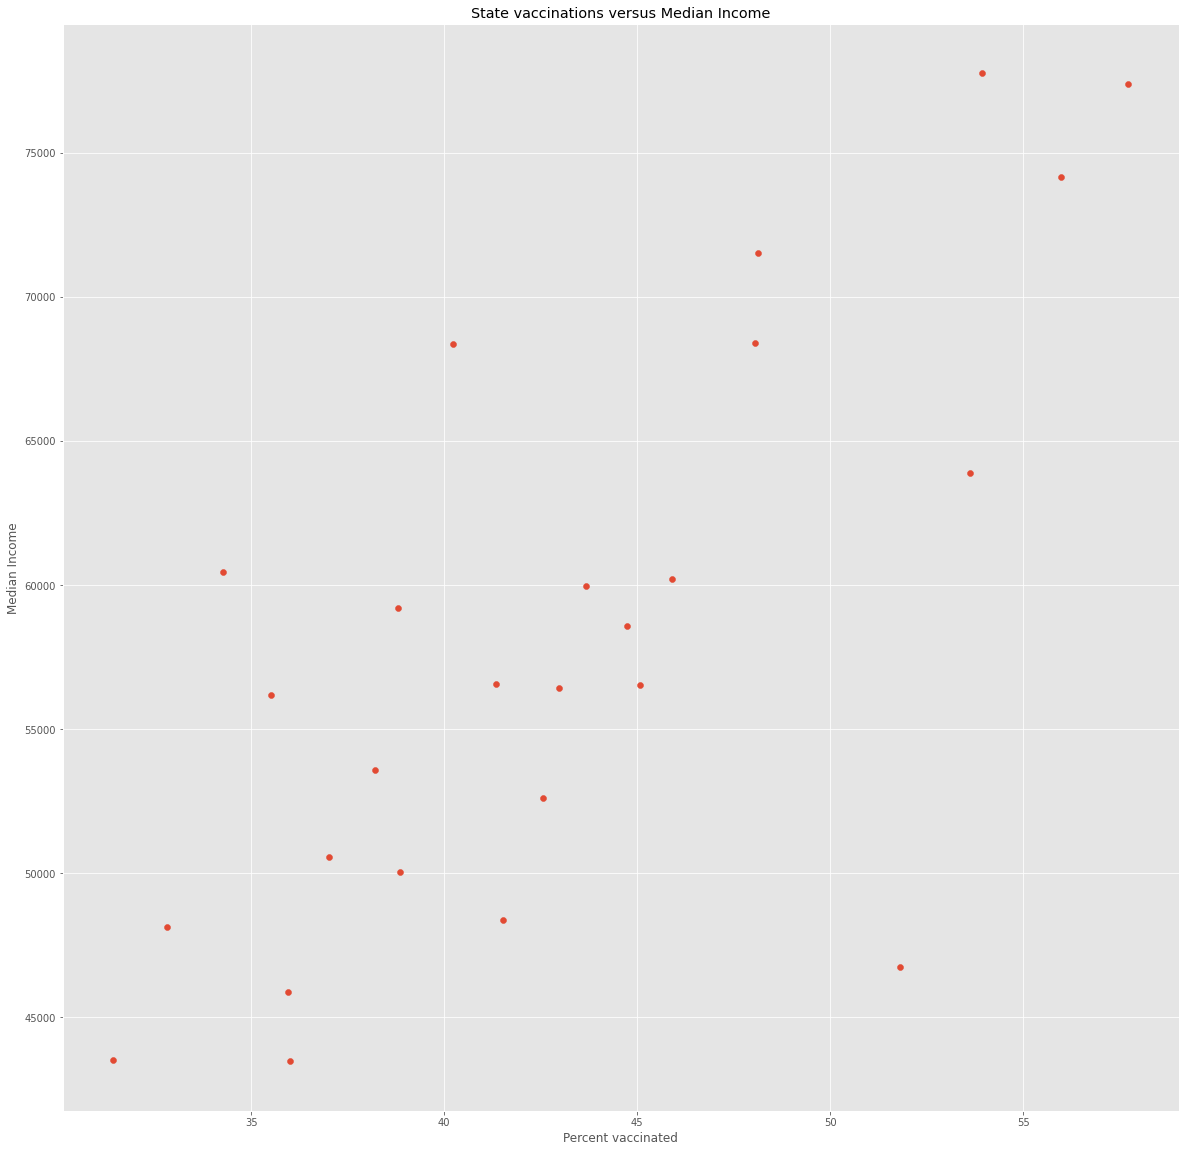

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import redirect_stdout

vax_vs_income = income_and_vax_df.select("State", "Median Income", "people_vaccinated_per_hundred")
median_income = list(vax_vs_income.select('Median Income').toPandas()['Median Income'])
percent_vax = list(vax_vs_income.select('people_vaccinated_per_hundred').toPandas()['people_vaccinated_per_hundred'])


plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (20, 20)

#plot percent vaccinations vs median income for states
plt.scatter(percent_vax, median_income)
plt.title('State vaccinations versus Median Income')
plt.xlabel('Percent vaccinated')
plt.ylabel('Median Income')
plt.show()

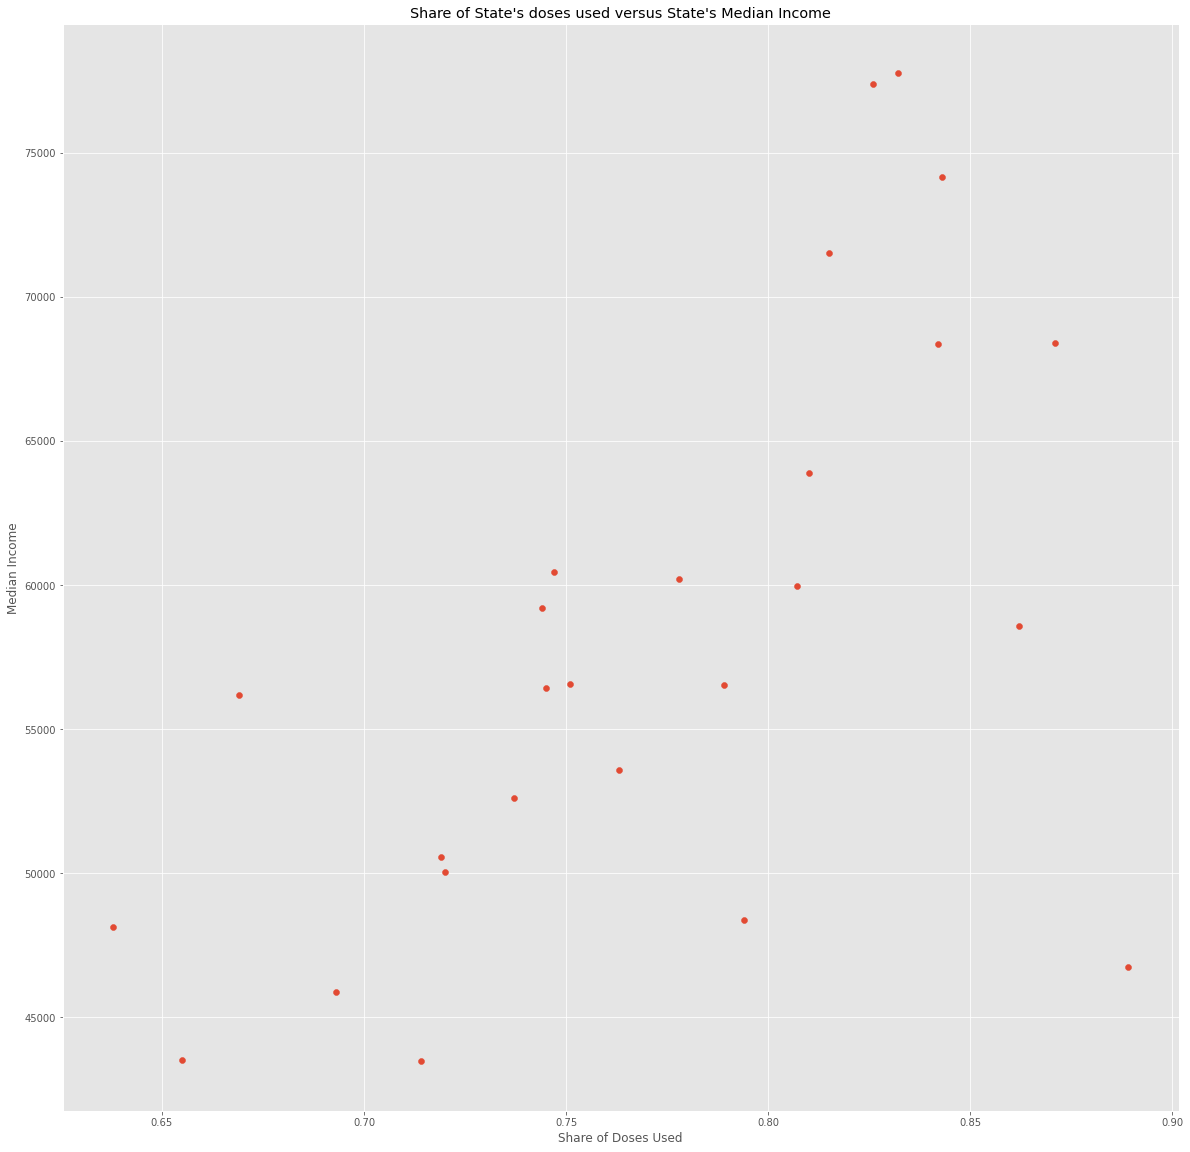

In [29]:
vax_vs_income = income_and_vax_df.select('State', 'Median Income', 'share_doses_used')
doses_used = list(vax_vs_income.select('share_doses_used').toPandas()['share_doses_used'])

#plot doses used
plt.scatter(doses_used, median_income)
plt.title("Share of State's doses used versus State's Median Income")
plt.xlabel('Share of Doses Used')
plt.ylabel('Median Income')
plt.show()

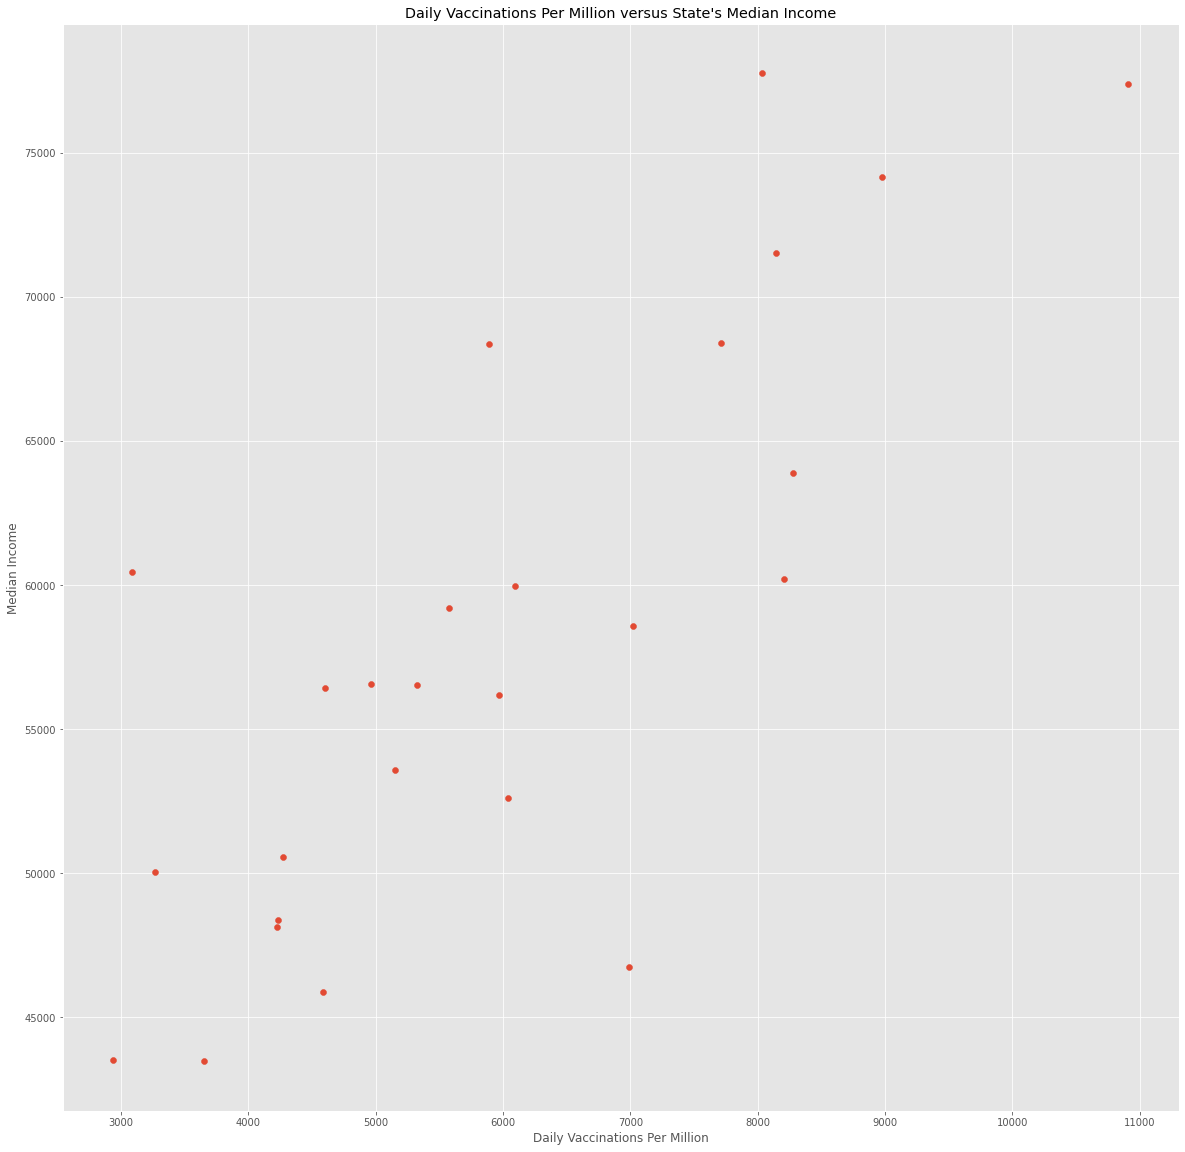

In [30]:
vax_vs_income = income_and_vax_df.select('State', 'Median Income', 'daily_vaccinations_per_million')
daily_vax = list(vax_vs_income.select('daily_vaccinations_per_million').toPandas()['daily_vaccinations_per_million'])

#plot doses used
plt.scatter(daily_vax, median_income)
plt.title("Daily Vaccinations Per Million versus State's Median Income")
plt.xlabel('Daily Vaccinations Per Million')
plt.ylabel('Median Income')
plt.show()

These graphs all show that there clearly is a relationship between a state's median income and its progress with the Covid-19 vaccination rollout. We will use KNN analysis to see how useful these vaccination data features we've graphed are for predicting a state's median income.

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import array as array
from sklearn import preprocessing
from sklearn import utils

#select the columns that will be used for the knn model
knn_df = income_and_vax_df.select('Median Income', 'daily_vaccinations_per_million', 'share_doses_used', 'people_vaccinated_per_hundred')

#create feature and target arrays
knn_data = np.array(knn_df.select('daily_vaccinations_per_million', 'share_doses_used', 'people_vaccinated_per_hundred').collect())
knn_target = np.array(knn_df.select('Median Income').collect())

#use np.ravel() to convert the target array to the proper format
knn_target = np.ravel(knn_target)

#convert target data to categorical. KNN does not allow float values in the target set
le = preprocessing.LabelEncoder()
knn_target= le.fit_transform(knn_target)

#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(knn_data, knn_target, test_size=0.4, random_state=42)

#create the model
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train, y_train)

#test the model
print(knn.predict(X_test))

#get the accuracy score for the model
print(knn.score(X_test, y_test))

[7 1 1 1 3 1 3 7 3 3 7]
0.0


KNN analysis did not prove useful for predicting this relationship. This could be due to the relationship not being easily converted to a categorical nature. 

Next, we will try using a linear regression model. 

Because we needed to remove certain columns from the dataset we were using, we were getting missing cells that were reading as NULL values. I found the following code to resolve this issue and cleanup missing cells and NULL values. Reference: https://stackoverflow.com/a/46581125

In [32]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [73]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

#load dataset, don't use the first two columns which are 'date' and 'location'
train = pd.read_csv(r"states_plus_income.csv",
                    usecols=[2,3,4,5,6,7,8,9,10,11,12,13,14])

#clean the dataset of missing cells and null values after removing columns
train = clean_dataset(train)

#separate dataset into input and output variables. 
#x is input y is output
y = np.log(train.median_income_2017)
x = train.drop(['median_income_2017'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=.33)
lrl = linear_model.LinearRegression()
model = lrl.fit(X_train, y_train)
print("R2 is:", model.score(X_test, y_test))
prediction = model.predict(X_test)
print("RMSE is:", mean_squared_error(y_test, prediction))


R2 is: -0.38469233530629454
RMSE is: 0.04312368448212478


We can try to improve our score by finding which of our input variables are the most useful and rerunning the linear regression model with only those variables 

In [34]:
#find columns with strongest relationship to median income
target = np.log(train.median_income_2017)
numeric_features = train.select_dtypes(include=[np.number])
corr = numeric_features.corr()
print("Columns with highest correlation to Median Income: ")
print(corr['median_income_2017'].sort_values(ascending=False)[:6],'\n')

#rebuild linear regression model
y = np.log(train.median_income_2017)
x = train[['people_vaccinated_per_hundred', 'total_vaccinations_per_hundred', 
           'distributed_per_hundred', 'daily_vaccinations_per_million', 
           'share_doses_used']]

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=.33)
lrl = linear_model.LinearRegression()
model = lrl.fit(X_train, y_train)
print("R2 is:", model.score(X_test, y_test))
prediction = model.predict(X_test)
print("RMSE is:", mean_squared_error(y_test, prediction))



Columns with highest correlation to Median Income: 
median_income_2017                1.000000
people_vaccinated_per_hundred     0.632240
total_vaccinations_per_hundred    0.621925
distributed_per_hundred           0.572735
daily_vaccinations_per_million    0.534575
share_doses_used                  0.422397
Name: median_income_2017, dtype: float64 

R2 is: 0.6644289108721115
RMSE is: 0.010450741583452926


Decreasing our input variables to the model increased the score and also resulted in a lower RMSE value, which indicates a better fit of the model to the data.

## Global Vaccine Data

We will perform similar visualization as we did above, but this time we are looking at global Covid-19 vaccine progress on a country-by-country basis. We will be using the "country_vaccinations_most_recent.csv" dataset to get information about vaccination for each country. We will also use several different datasets which contain different methods of determining a country's economic standing. 



In [55]:
global_vaccine_df = spark.read.csv('country_vaccinations_most_recent.csv', inferSchema=True, header=True)
global_vaccine_df.show(10)

temp = spark.read.csv('minimum_wage.csv', inferSchema=True, header=True)
work_df = temp.select('Country', 'Hourly-Nominal (US$)', 'Annual-PPP (Int$)', 'Annual-Nominal (US$)')
work_df.show(10)

temp = spark.read.csv('Life Expectancy Data.csv', inferSchema=True, header=True)
life_expectancy_df = temp.select('Country', 'Year', 'Status',
                                 'Life expectancy ', 'Population').filter(temp.Year == 2015)
life_expectancy_df.show(10)

temp = spark.read.csv('GDP.csv', inferSchema=True, header=True)
gdp_df = temp.select('Country ', '2018')
gdp_df.show(10)


+-------------------+--------+---------+------------------+-----------------+-----------------------+----------------------+------------------+------------------------------+-----------------------------+-----------------------------------+------------------------------+--------------------+--------------------+--------------------+
|            country|iso_code|     date|total_vaccinations|people_vaccinated|people_fully_vaccinated|daily_vaccinations_raw|daily_vaccinations|total_vaccinations_per_hundred|people_vaccinated_per_hundred|people_fully_vaccinated_per_hundred|daily_vaccinations_per_million|            vaccines|         source_name|      source_website|
+-------------------+--------+---------+------------------+-----------------+-----------------------+----------------------+------------------+------------------------------+-----------------------------+-----------------------------------+------------------------------+--------------------+--------------------+-----------------

Now that we have all of our dataframes created with the features selected that we want to work with, we are going to join these different datasets on the basis of country. 

In [70]:
#rename column name so it's usable to join tables
gdp_df = gdp_df.withColumnRenamed('Country ', 'country')
gdp_df = gdp_df.withColumnRenamed('2018', 'gdp')

#join dataframes
temp_combined = global_vaccine_df.join(work_df, global_vaccine_df.country == work_df.Country, 'inner')
another_temp_combined = temp_combined.join(life_expectancy_df, global_vaccine_df.country == life_expectancy_df.Country, 'inner')
combined_global_df = another_temp_combined.join(gdp_df, global_vaccine_df.country == gdp_df.country, 'inner')

drop_nulls_df = spark.read.csv('country_vaccinations_drop_null.csv', inferSchema=True, header=True)
vax_work_df = drop_nulls_df.join(work_df, drop_nulls_df.country == work_df.Country, 'inner')
vax_life_expectancy_df = drop_nulls_df.join(life_expectancy_df, drop_nulls_df.country == life_expectancy_df.Country, 'inner')
vax_join_gdp_df = drop_nulls_df.join(gdp_df, drop_nulls_df.country == gdp_df.country, 'inner')
#print new combined df
combined_global_df.show(10)

+-------------------+--------+---------+------------------+-----------------+-----------------------+----------------------+------------------+------------------------------+-----------------------------+-----------------------------------+------------------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-----------------+--------------------+-------------------+----+----------+----------------+-----------+-------------------+-----------+
|            country|iso_code|     date|total_vaccinations|people_vaccinated|people_fully_vaccinated|daily_vaccinations_raw|daily_vaccinations|total_vaccinations_per_hundred|people_vaccinated_per_hundred|people_fully_vaccinated_per_hundred|daily_vaccinations_per_million|            vaccines|         source_name|      source_website|            Country|Hourly-Nominal (US$)|Annual-PPP (Int$)|Annual-Nominal (US$)|            Country|Year|    Status|Life expectancy | Population|         

We now have all of the information that we need in our dataframes, so we can do some graphing to look at the relationships between our data.

We will first graph GDP vs total vaccinations.

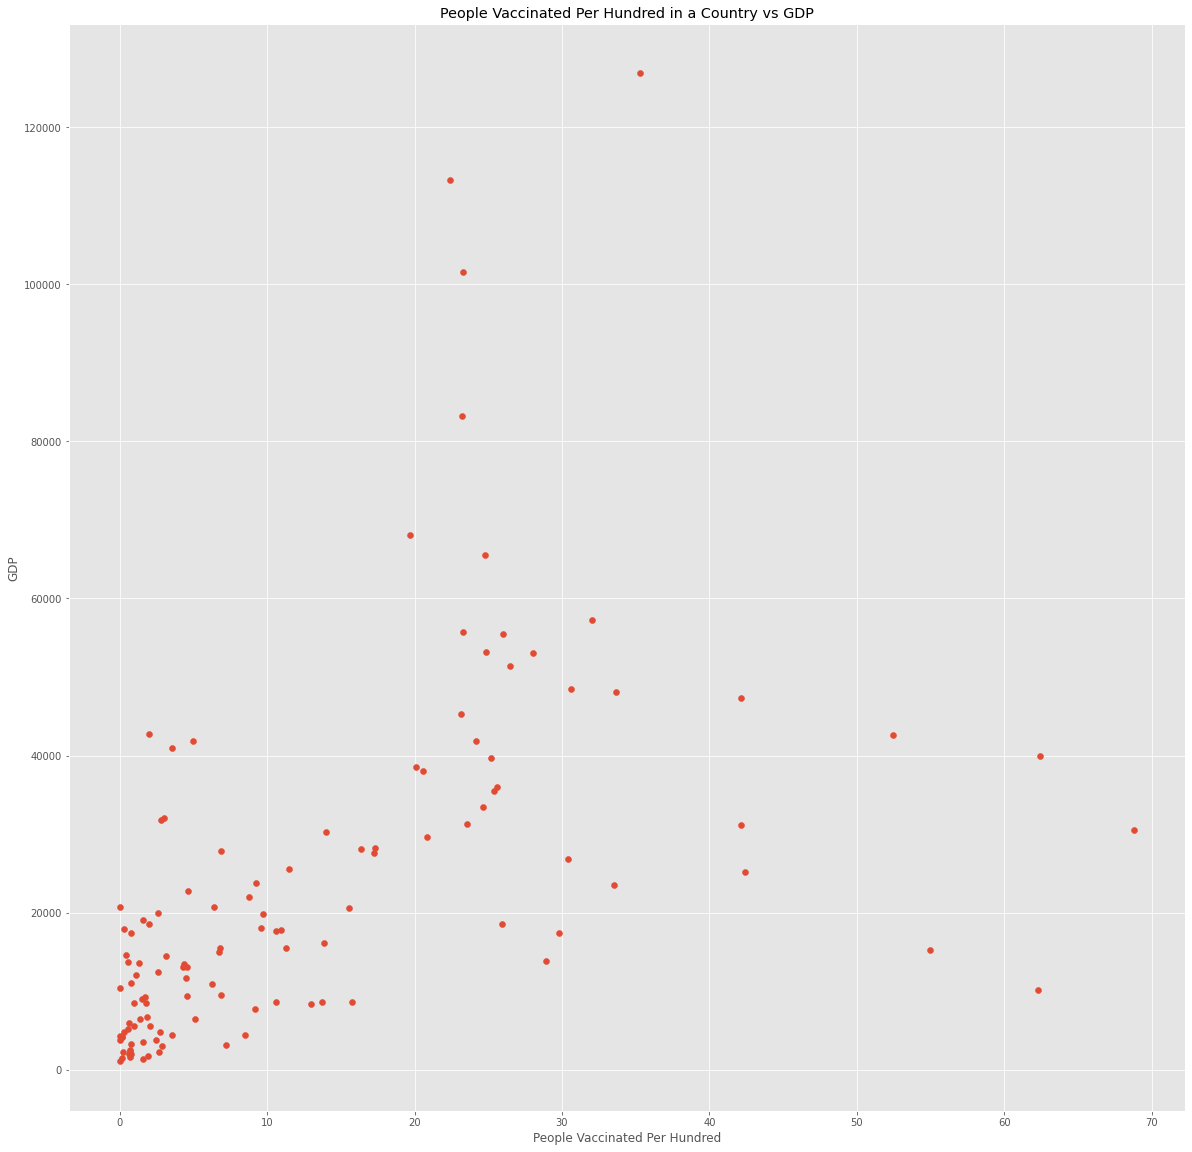

In [61]:

plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (20, 20)

gdp_vs_vax = combined_global_df.select("gdp", "people_vaccinated_per_hundred")
gdp_graph_data = list(gdp_vs_vax.select("gdp").toPandas()["gdp"])
vax_graph_data = list(gdp_vs_vax.select('people_vaccinated_per_hundred').toPandas()['people_vaccinated_per_hundred'])

plt.scatter(vax_graph_data, gdp_graph_data)
plt.title('People Vaccinated Per Hundred in a Country vs GDP')
plt.xlabel('People Vaccinated Per Hundred')
plt.ylabel('GDP')
plt.show()

There seems to be a little bit of a relationship between these features, but it is definitely not a strict correlation.

Next we will look at life expectancy vs. people vaccinated per hundred.

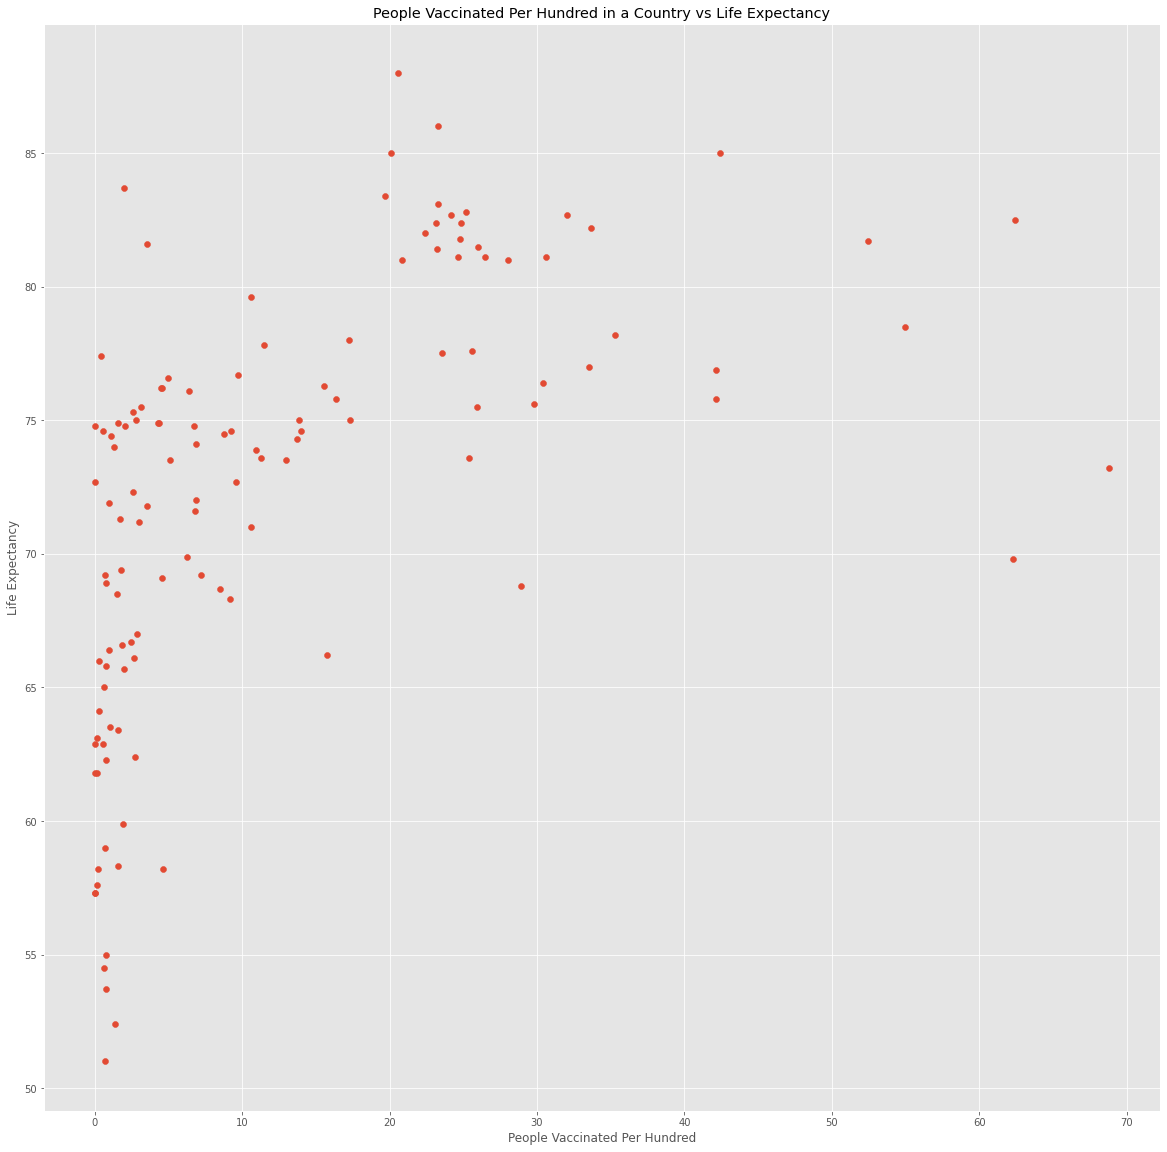

In [62]:
gdp_vs_vax = combined_global_df.select("Life expectancy ", "people_vaccinated_per_hundred")
life_expectancy_graph_data = list(gdp_vs_vax.select("Life expectancy ").toPandas()["Life expectancy "])
vax_graph_data = list(gdp_vs_vax.select('people_vaccinated_per_hundred').toPandas()['people_vaccinated_per_hundred'])

plt.scatter(vax_graph_data, life_expectancy_graph_data)
plt.title('People Vaccinated Per Hundred in a Country vs Life Expectancy')
plt.xlabel('People Vaccinated Per Hundred')
plt.ylabel('Life Expectancy')
plt.show()

There is definitely a strong relationship between these two variables, as the graph shows that all of the countries with low life expectancy also have low vaccination rates.

Next we will look at minimum wage vs. people vaccinated per hundred.

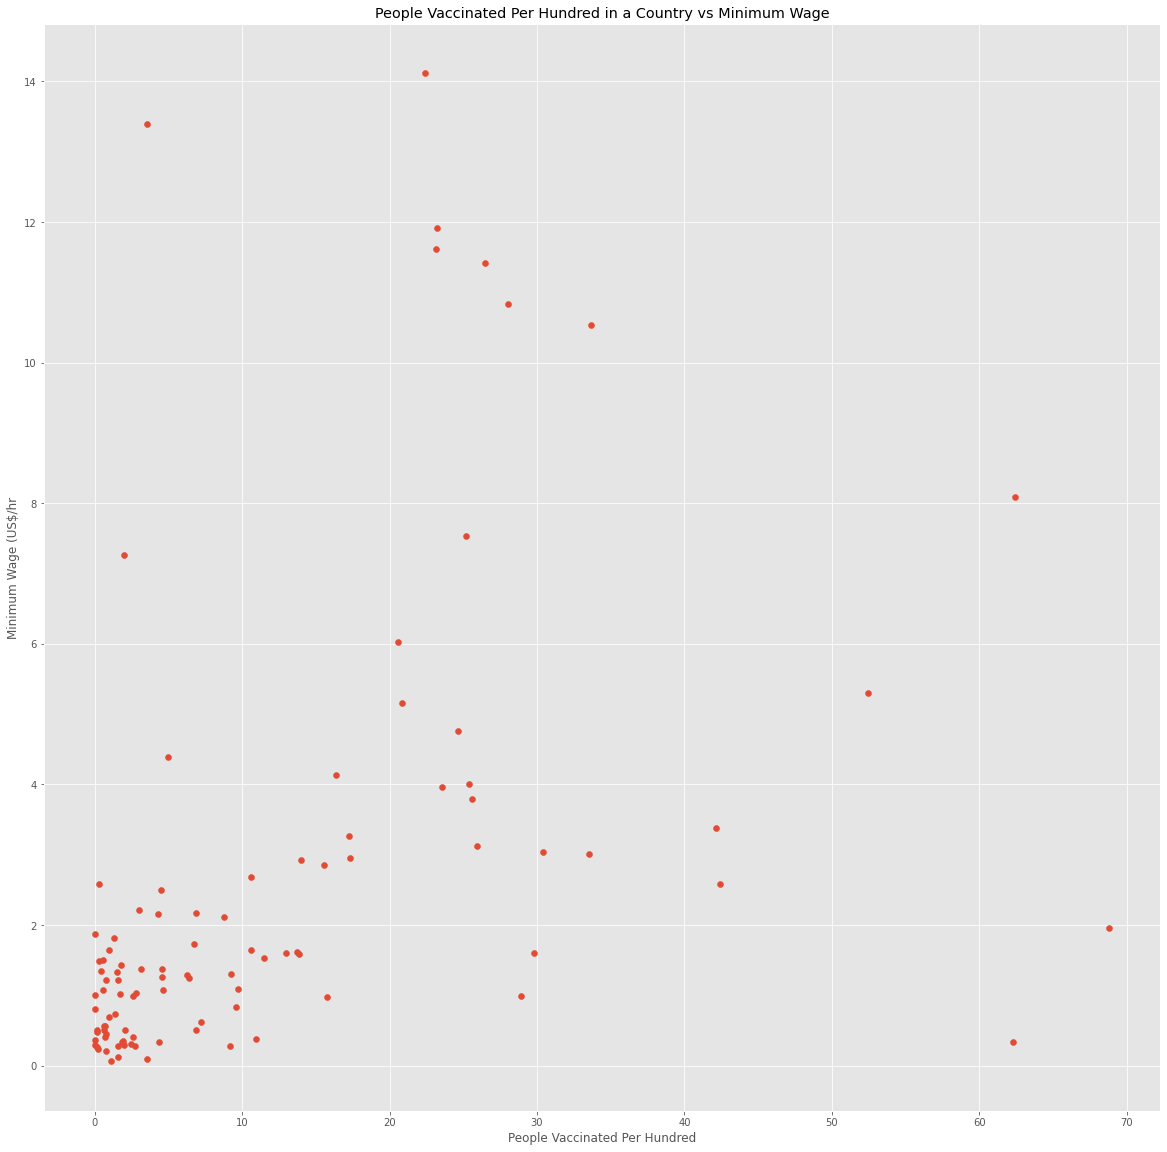

In [63]:
gdp_vs_vax = combined_global_df.select("people_vaccinated_per_hundred", "Hourly-Nominal (US$)")
min_wage_graph_data = list(gdp_vs_vax.select("Hourly-Nominal (US$)").toPandas()["Hourly-Nominal (US$)"])
vax_graph_data = list(gdp_vs_vax.select('people_vaccinated_per_hundred').toPandas()['people_vaccinated_per_hundred'])

plt.scatter(vax_graph_data, min_wage_graph_data)
plt.title('People Vaccinated Per Hundred in a Country vs Minimum Wage')
plt.xlabel('People Vaccinated Per Hundred')
plt.ylabel('Minimum Wage (US$/hr')
plt.show()

Again there is some of a correlation here, with most of the low vaccination rates and low hourly wage rates being grouped together.

Lastly, we will visualize 

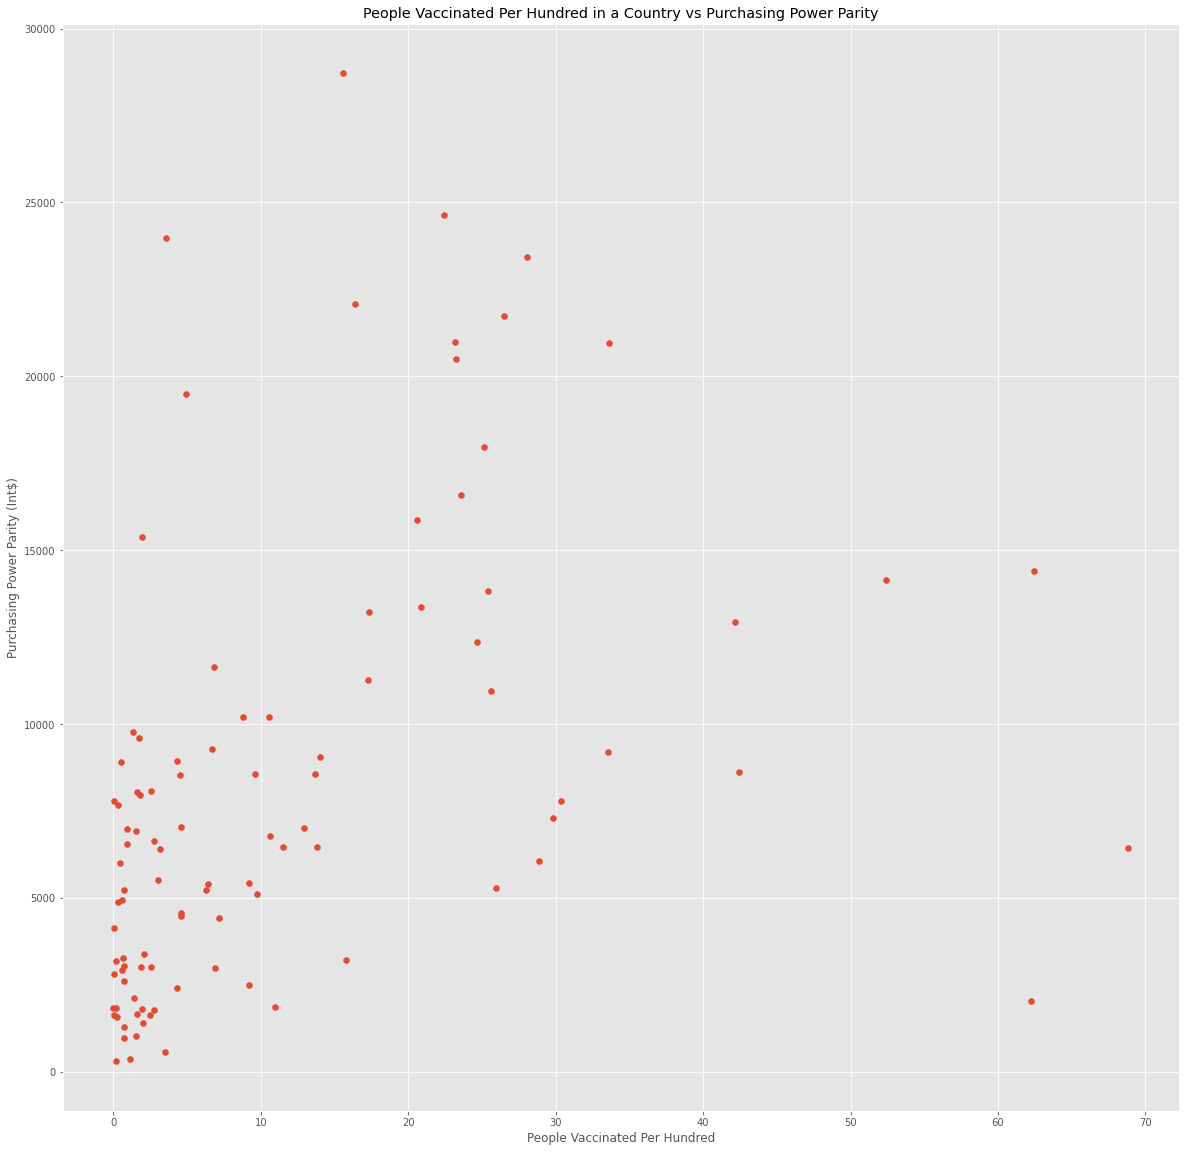

In [64]:
gdp_vs_vax = combined_global_df.select("people_vaccinated_per_hundred", "Annual-PPP (Int$)")
ppp_graph_data = list(gdp_vs_vax.select("Annual-PPP (Int$)").toPandas()["Annual-PPP (Int$)"])
vax_graph_data = list(gdp_vs_vax.select('people_vaccinated_per_hundred').toPandas()['people_vaccinated_per_hundred'])

plt.scatter(vax_graph_data, ppp_graph_data)
plt.title('People Vaccinated Per Hundred in a Country vs Purchasing Power Parity')
plt.xlabel('People Vaccinated Per Hundred')
plt.ylabel('Purchasing Power Parity (Int$)')
plt.show()

While still having somewhat of a correlation between features, this graph had one of the weakest relationships. 

We will move onto KNN analysis of vaccine data and its ability to predict the categorical column 'Status'. This column has the values of either 'Developed' or 'Developing'.

In [65]:
# drop rows that contain null values for the selected columns
knn_df = vax_life_expectancy_df.select('people_vaccinated_per_hundred', 'Population', 'Status', 'total_vaccinations')
knn_df_drop = knn_df.dropna()

#create feature and target arrays
knn_data = np.array(knn_df_drop.select('people_vaccinated_per_hundred', 'Population', 'total_vaccinations').collect())
knn_target = np.array(knn_df_drop.select('Status').collect())

#use np.ravel() to convert the target array to the proper format
knn_target = np.ravel(knn_target)

#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(knn_data, knn_target, test_size=0.2, random_state=42)

#create the model
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train, y_train)

#test the model
print(knn.predict(X_test))

#get the accuracy score for the model
print(knn.score(X_test, y_test))

['Developing' 'Developed' 'Developing' 'Developing' 'Developing'
 'Developing' 'Developing' 'Developing' 'Developing' 'Developing'
 'Developing' 'Developing' 'Developing' 'Developing' 'Developing'
 'Developing' 'Developing' 'Developing' 'Developing' 'Developing'
 'Developing' 'Developing' 'Developing' 'Developing']
0.8333333333333334


This model had a good accuracy score for predicting status based on factors like percentage of people vaccinated.

We can repeat the linear regression model we made above with our global dataset.

In [66]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

#rename columns so they're usable with pandas
vax_work_df = vax_work_df.withColumnRenamed('Hourly-Nominal (US$)', 'hourly_wage')
vax_work_df = vax_work_df.withColumnRenamed('Annual-PPP (Int$)', 'ppp')
vax_work_df = vax_work_df.withColumnRenamed('Annual-Nominal (US$)', 'annual_nominal')

#get the columns needed
regression_df_1 = vax_work_df.select('total_vaccinations', 'total_vaccinations_per_hundred', 
                                     'daily_vaccinations_per_million', 'hourly_wage', 'ppp', 'annual_nominal')
regression_df_1.show(10)

#convert pyspark df to pandas df
train = regression_df_1.toPandas()

#get rid of null values
train = clean_dataset(train)

#separate dataset into input and output variables
#x is input y is output
y = np.log(train.total_vaccinations)
x = train.drop(['total_vaccinations', 'total_vaccinations_per_hundred', 'daily_vaccinations_per_million'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=.33)
lrl = linear_model.LinearRegression()
model = lrl.fit(X_train, y_train)
print("Total Vaccinations: ")
print("R2 is:", model.score(X_test, y_test))
prediction = model.predict(X_test)
print("RMSE is:", mean_squared_error(y_test, prediction))

+------------------+------------------------------+------------------------------+-----------+-----+--------------+
|total_vaccinations|total_vaccinations_per_hundred|daily_vaccinations_per_million|hourly_wage|  ppp|annual_nominal|
+------------------+------------------------------+------------------------------+-----------+-----+--------------+
|            240000|                          0.62|                           206|        0.5| 3272|          1047|
|             26414|                         34.19|                         13590|       6.85|11020|         14243|
|            456349|                          1.39|                           509|       0.73| 2108|          1681|
|             29754|                         30.38|                          2553|       3.04| 7788|          6317|
|           7997902|                          17.7|                          2728|       2.85|28722|          7108|
|               565|                          0.02|                     

RMSE is high for this model, which means that the model is not fit to the data well.

In [67]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

#rename columns so they're usable with pandas
vax_work_df = vax_work_df.withColumnRenamed('Hourly-Nominal (US$)', 'hourly_wage')
vax_work_df = vax_work_df.withColumnRenamed('Annual-PPP (Int$)', 'ppp')
vax_work_df = vax_work_df.withColumnRenamed('Annual-Nominal (US$)', 'annual_nominal')

#get the columns needed
regression_df_1 = vax_work_df.select('total_vaccinations', 'total_vaccinations_per_hundred', 
                                     'daily_vaccinations_per_million', 'hourly_wage', 'ppp', 'annual_nominal')
regression_df_1.show(10)

#convert pyspark df to pandas df
train = regression_df_1.toPandas()

#get rid of null values
train = clean_dataset(train)

#separate dataset into input and output variables
#x is input y is output
y = np.log(train.daily_vaccinations_per_million)
x = train.drop(['total_vaccinations', 'total_vaccinations_per_hundred', 'daily_vaccinations_per_million'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=.33)
lrl = linear_model.LinearRegression()
model = lrl.fit(X_train, y_train)
print("Daily Vaccinations Per Million: ")
print("R2 is:", model.score(X_test, y_test))
prediction = model.predict(X_test)
print("RMSE is:", mean_squared_error(y_test, prediction))

+------------------+------------------------------+------------------------------+-----------+-----+--------------+
|total_vaccinations|total_vaccinations_per_hundred|daily_vaccinations_per_million|hourly_wage|  ppp|annual_nominal|
+------------------+------------------------------+------------------------------+-----------+-----+--------------+
|            240000|                          0.62|                           206|        0.5| 3272|          1047|
|             26414|                         34.19|                         13590|       6.85|11020|         14243|
|            456349|                          1.39|                           509|       0.73| 2108|          1681|
|             29754|                         30.38|                          2553|       3.04| 7788|          6317|
|           7997902|                          17.7|                          2728|       2.85|28722|          7108|
|               565|                          0.02|                     

The RMSE is lower when we used the column 'daily_vaccinations_per_million', however it is still relatively high.

In [68]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

#rename columns so they're usable with pandas
vax_work_df = vax_work_df.withColumnRenamed('Hourly-Nominal (US$)', 'hourly_wage')
vax_work_df = vax_work_df.withColumnRenamed('Annual-PPP (Int$)', 'ppp')
vax_work_df = vax_work_df.withColumnRenamed('Annual-Nominal (US$)', 'annual_nominal')

#get the columns needed
regression_df_1 = vax_work_df.select('total_vaccinations', 'total_vaccinations_per_hundred', 
                                     'daily_vaccinations_per_million', 'hourly_wage', 'ppp', 'annual_nominal')
regression_df_1.show(10)

#convert pyspark df to pandas df
train = regression_df_1.toPandas()

#get rid of null values
train = clean_dataset(train)

#separate dataset into input and output variables
#x is input y is output
y = np.log(train.total_vaccinations_per_hundred)
x = train.drop(['total_vaccinations', 'total_vaccinations_per_hundred', 'daily_vaccinations_per_million'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=.33)
lrl = linear_model.LinearRegression()
model = lrl.fit(X_train, y_train)
print("Total Vaccinations Per Hundred")
print("R2 is:", model.score(X_test, y_test))
prediction = model.predict(X_test)
print("RMSE is:", mean_squared_error(y_test, prediction))

+------------------+------------------------------+------------------------------+-----------+-----+--------------+
|total_vaccinations|total_vaccinations_per_hundred|daily_vaccinations_per_million|hourly_wage|  ppp|annual_nominal|
+------------------+------------------------------+------------------------------+-----------+-----+--------------+
|            240000|                          0.62|                           206|        0.5| 3272|          1047|
|             26414|                         34.19|                         13590|       6.85|11020|         14243|
|            456349|                          1.39|                           509|       0.73| 2108|          1681|
|             29754|                         30.38|                          2553|       3.04| 7788|          6317|
|           7997902|                          17.7|                          2728|       2.85|28722|          7108|
|               565|                          0.02|                     

Again, a fairly high RMSE. I believe the reason the model is not fitting well to the data is because while there is a relationship between these features, it is not strictly linear. 

In [71]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

#rename columns so they're usable with pandas
regression_df_1 = vax_join_gdp_df.select('total_vaccinations', 'total_vaccinations_per_hundred', 
                                     'daily_vaccinations_per_million', 'gdp')

regression_df_1.show(10)

#convert pyspark df to pandas df
train = regression_df_1.toPandas()

#get rid of null values
train = clean_dataset(train)

#separate dataset into input and output variables
#x is input y is output
y = np.log(train.daily_vaccinations_per_million)
x = train.drop(['total_vaccinations', 'total_vaccinations_per_hundred', 'daily_vaccinations_per_million'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=.33)
lrl = linear_model.LinearRegression()
model = lrl.fit(X_train, y_train)
print("Daily Vaccinations Per Million with GDP: ")
print("R2 is:", model.score(X_test, y_test))
prediction = model.predict(X_test)
print("RMSE is:", mean_squared_error(y_test, prediction))

+------------------+------------------------------+------------------------------+-----------+
|total_vaccinations|total_vaccinations_per_hundred|daily_vaccinations_per_million|        gdp|
+------------------+------------------------------+------------------------------+-----------+
|             76865|                         71.99|                         11933|       null|
|            240000|                          0.62|                           206|1955.006208|
|            456349|                          1.39|                           509|6452.355165|
|           7997902|                          17.7|                          2728|20610.56855|
|               565|                          0.02|                          null|10343.17559|
|             29754|                         30.38|                          2553|26868.13352|
|           3194219|                         35.47|                          5416|55454.68929|
|           1516923|                         14.96

In [74]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

#rename columns so they're usable with pandas
vax_life_expectancy_df = vax_life_expectancy_df.withColumnRenamed('Life expectancy ', 'life_expectancy')

regression_df_1 = vax_life_expectancy_df.select('total_vaccinations', 'total_vaccinations_per_hundred', 
                                     'daily_vaccinations_per_million', 'life_expectancy')

regression_df_1.show(10)

#convert pyspark df to pandas df
train = regression_df_1.toPandas()

#get rid of null values
train = clean_dataset(train)

#separate dataset into input and output variables
#x is input y is output
y = np.log(train.daily_vaccinations_per_million)
x = train.drop(['total_vaccinations', 'total_vaccinations_per_hundred', 'daily_vaccinations_per_million'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=.33)
lrl = linear_model.LinearRegression()
model = lrl.fit(X_train, y_train)
print("Daily Vaccinations Per Million with Life Expectancy: ")
print("R2 is:", model.score(X_test, y_test))
prediction = model.predict(X_test)
print("RMSE is:", mean_squared_error(y_test, prediction))

+------------------+------------------------------+------------------------------+---------------+
|total_vaccinations|total_vaccinations_per_hundred|daily_vaccinations_per_million|life_expectancy|
+------------------+------------------------------+------------------------------+---------------+
|            240000|                          0.62|                           206|           65.0|
|            456349|                          1.39|                           509|           52.4|
|             29754|                         30.38|                          2553|           76.4|
|           7997902|                          17.7|                          2728|           76.3|
|               565|                          0.02|                          null|           74.8|
|           3194219|                         35.47|                          5416|           81.5|
|           1516923|                         14.96|                          1319|           72.7|
|         

## Conclusion

Through data visualization we were able to see that there was definitely a relationship between vaccine distribution and income level on both a United States and global level. For the United States, we used Median Income as the indicator of income. When we looked at global vaccination data, we worked with a few different datasets to see what economic factors had the strongest relationship to vaccine distribution. We graphed a few different features. For example, globally we graphed people vaccinated per hundred vs. gdp, and people vaccinated vs. life expectancy. We ran different linear regression models to see which economic factor produced the best accuracy score. Most of our models had a relatively high RMSE, which is an indicator of the model not fitting the data very well. The linear regression model that we built that had the highest accuracy score was daily vaccinations per million and life expectancy, which had a score of 54.92%. 

Overall, our data analysis showed that economic factors have an impact on both national and international Covid-19 vaccination rates. However, global vaccination seems to have more factors that are causing this to not be as strict a linear relationship as it is in the United States.